In [33]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import gzip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate

In [13]:
# LOCAL = 'Avenches'
LOCAL = 'Lausanne'

#### Download files :

In [14]:
# Specify the file paths
activity_file = 'data_original/vaud_activities.csv.gz'
population_file = 'data_original/vaud_population.csv.gz'
trip_file = 'data_original/vaud_trips.csv.gz'

# Read the gzipped CSV files
def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

# Read the dataframes
activity_vaud = read_gzipped_csv(activity_file)
population_vaud = read_gzipped_csv(population_file)[['id', 'age', 'home_x', 'home_y', 'local']].drop_duplicates()
trip_vaud = read_gzipped_csv(trip_file)[['Unnamed: 0', 'id', 'mode', 'dep_time','trav_time','start_link','end_link']].drop_duplicates()

In [15]:
output_csv = pd.read_csv("./data_output/schedules.csv")

#### Generic functions :

In [16]:
# Create palette of colors for the facilities type
palette = sns.color_palette("husl", n_colors=len(set(activity_vaud['type'])))
color_palette = dict(zip(set(activity_vaud['type']), palette))
color_palette['transport'] = 'grey'

In [17]:
def plot_schedule(activity_df, individual_id):
    # Filter the DataFrame for the specific id
    # ASSUMPTION : les activites sont deja chronologiques pour chaque individual id : OUI
    # ASSUMPTION : chaque individu n'a qu'une journee dans le dataframe : OUI
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    
    segments = []
    colors = []
    fig, ax = plt.subplots(figsize=(10, 1))
    
    start_of_day = datetime.strptime('00:00:00', '%H:%M:%S')
    end_of_day = datetime.strptime('23:59:59', '%H:%M:%S')
    prev_end = start_of_day
    
    for _, facility in individual_schedule.iterrows():
        start_time = datetime.strptime(facility['start_time'], '%H:%M:%S') if pd.notna(facility['start_time']) else start_of_day
        end_time = datetime.strptime(facility['end_time'], '%H:%M:%S') if pd.notna(facility['end_time']) else end_of_day
        
        if prev_end < start_time:
            segments.append([(prev_end - start_of_day).total_seconds() / 3600, (start_time - prev_end).total_seconds() / 3600])
            colors.append(color_palette['transport'])
            ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
            
        segments.append([(start_time - start_of_day).total_seconds() / 3600, (end_time - start_time).total_seconds() / 3600])
        colors.append(color_palette[facility['type']])
        ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
        
        prev_end = end_time


    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlim(0, 24)
    ax.set_yticks([])
    ax.set_xticks(range(25))
    ax.set_xlabel('Time (hours)')
    plt.show()

In [29]:
def print_schedule(activity_df, individual_id):
    # Filter the DataFrame for the specific id
    # ASSUMPTION : les activites sont deja chronologiques pour chaque individual id : OUI
    # ASSUMPTION : chaque individu n'a qu'une journee dans le dataframe : OUI
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    print(tabulate(individual_schedule, headers='keys', tablefmt='pipe'))

In [31]:
def horizons_to_timedelta(n):
    minutes = n * 5
    time_delta = timedelta(minutes=minutes)
    return time_delta

#### Tests :

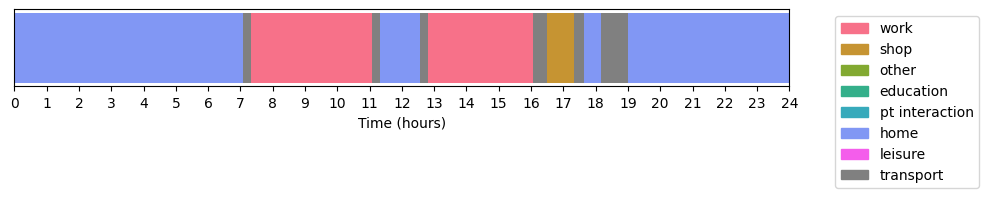

|         |   Unnamed: 0 |      id | type   | facility    |   link |           x |           y | start_time   | end_time   |
|--------:|-------------:|--------:|:-------|:------------|-------:|------------:|------------:|:-------------|:-----------|
| 4377485 |     36624115 | 7120345 | home   | home3124988 | 129407 | 2.53731e+06 | 1.1523e+06  | nan          | 07:04:18   |
| 4377486 |     36624116 | 7120345 | work   | 223384      | 596687 | 2.53934e+06 | 1.15468e+06 | 07:19:18     | 11:04:18   |
| 4377487 |     36624117 | 7120345 | home   | home3124988 | 129407 | 2.53731e+06 | 1.1523e+06  | 11:19:18     | 12:34:18   |
| 4377488 |     36624118 | 7120345 | work   | 223384      | 596687 | 2.53934e+06 | 1.15468e+06 | 12:49:18     | 16:04:18   |
| 4377489 |     36624119 | 7120345 | shop   | 398396      | 205618 | 2.53611e+06 | 1.15773e+06 | 16:29:18     | 17:19:18   |
| 4377490 |     36624120 | 7120345 | home   | home3124988 | 129407 | 2.53731e+06 | 1.1523e+06  | 17:39:18     | 18:09:18   |


In [30]:
individual_id = 7120345 
plot_schedule(activity_vaud, individual_id)
print_schedule(activity_vaud, individual_id)